In [1]:
#%matplotlib notebook

from numpy import sort as srt,cov,bitwise_or,array,corrcoef


from sklearn.ensemble import RandomForestRegressor
max_depth=10

from seaborn import pairplot





# Random scores and their losses for binary classification
- Work with randomly distributed feature and target data $(x,y)$ taking values in $\in\mathcal X\times\mathcal Y$, want to be able to theoretically justify a prediction $\hat y$ we make for $y$
- Classification is the case where $\mathcal Y$ is a finite set $\#\mathcal Y=N_{\texttt{lab}}<\infty$ of possible target label values - statistics about such models take discrete values but the random setting means that objectives can be related in a natural way to continuous valued functions

### Possible scores for a single prediction
- Feature and target data $(x,y)$ taking values in $\mathcal X\times\mathcal Y$, want to be able to theoretically justify a prediction $\hat y$ for $y$
- Generallity allow predictions to depend on varying costs of misclassifications
- To compute some statistic $c$ about a classification a user first has to fix some function of the possible prediction and outcomes $(\hat y,y)\in\mathcal Y^2$
- For classification any such function can be represented by its values on the $N^2$ possible outcomes so that $c=C_s(\hat y,y)$ where $s$ is an RV taking values in a finite dimensional space of parameters $\Sigma$
- Assuming a misclassification is always worse than a correct classification, we can rescale by eg subtracting any profits that would be gained from a correct prediction and restrict to an $N^2-N$ dimensional family of misclassification costs
- For binary classification $N=2$ this means that up to a rescaling there are only two degrees of freedom for possible prediction-outcome pairs and the random statistic can be written
$$
c=C_\sigma(\hat y,y)
$$
where $\sigma_-=C_\sigma(+,-)$ and $\sigma_+=C_\sigma(-,+)$ are the costs of a false positive and false positive respectively
- For fixed sampled value of $\sigma$ can write down a Bayes rule in terms of the marginals
$$
y^*(x',\sigma)=\begin{cases}+\text{ if }\rho(x')=\frac{\mathbb P(+|x=x')}{\mathbb P(-|x=x')}>\frac{\sigma_+}{\sigma_-},\\-\text{ otherwise}\end{cases}
$$
    - This means that for a fixed $\kappa=\frac{\sigma_+}{\sigma_-}$ the optimal solution just checks whether the relative likelihood is greater than $\kappa$

### Theory and practice
- We will find that in this case it is a bad idea to assume that a model trained using BCE is well calibrated in that its outputs behave akin to a marginal distribution
- This isn't necessarily a problem - such a model may still be useful - it is straightforward to use the training data to pick a cutoff that minimises expectations for a given cost ratio

# First experiments
First dataset to work with is cybersecurity: UNSW-NB15

In [22]:
from cal.dl import unsw
#data_unscaled=unsw(lab_cat=True,rescale=False)
data_rescaled=unsw(lab_cat=True,rescale=True)

- Depending on experimental procedure, need to split data etc, here: train-test split

In [23]:
(x_train,all_classes_train),(x_test,all_classes_test),(df_train,df_test),sc=data_rescaled


- First consider boring case where $\sigma$ is constant
- Rescaling $C$ by a constant doesn't change problem, can parameterise by a single number eg common choice $\beta^2=\frac{\sigma_-}{\sigma_+}$ or similar
- Can write expected cost for fixed feature $x=x'$ and prediction $\hat y=y'$ which we wish to minimise in expectation
$$
\mathbb E(C(y,y')|x=x')=\sigma_{-y'}\mathbb P(y=-y'|x=x')
$$

This has multiple classes, focus on one class for now:

In [24]:
y_train,y_test=all_classes_train=='Generic',all_classes_test=='Generic'

In [25]:
from cal.jal import shuffle_batched
from flax.nnx import relu#,Module
from flax.linen import Module,Dense
#from sklearn.ensemble import RandomForestRegressor
from typing import Sequence,Callable
from optax import adam,apply_updates
from optax.losses import sigmoid_binary_cross_entropy
from jax import grad,jit
from jax.numpy import array,log,argsort,cumsum,flip,argmin,argmax
from jax.lax import scan
from jax.tree import structure
from jax.nn import sigmoid

def inverse_sigmoid(probability): #sigmoid maps between probs and log rel likelihoods, want inverse
  return log(probability/(1-probability))
  

### BCE
- Write $(\Omega,\mathbb P,\sigma)$ for underlying random system
- Let $x$ and $y$ be RVs taking values in $\mathcal X$ and $\mathcal Y$, which we formally treat as maps from $\Omega$:
$$
\Omega\xrightarrow{x\times y}\mathcal X\times\mathcal Y
$$
- Interested in dependence of $y$ upon $x$
- Intuitively, if $y$ is in large part dependent upon the value of $x$, then there exists a model $\hat y(x)$ such that $\hat y\approx y$ in an appropriate sense
- If the user has access to everything is possible to represent $y$ as a random variable $z:\Omega\times\mathcal X\rightarrow\mathcal Y$ trivially by letting $z(\omega,x')=y(\omega)$, but we assume that they only have access to a factor $\Pi:\Omega\rightarrow\Omega'$ of $\Omega$ such that $x$ and $y$ are independent of $\Pi$.
- If we consider the RVs $u=(x,y)$ and $v=(x,z)$ representing a true system and an associated model their cross entropy is defined as
$$
H(u,v)=-\int_{\mathcal X\times\{\pm\}} f_u(x',y')\log(f_v(x',y'))\dee x'\dee y'
$$

BCE minimisation: given sampled features $x_j\in\mathcal X$ for $j\in I$ with corresponding targets $y_i\in\{\pm\}$ write $\tilde y=f_z(x)$.
Let $i$ be uniformly distributed in $I$, so that $x_i$ and $y_i$ are distributed empirically.
The sample cross entropy is the cross entropy of the RVs
$$
H((x_i,y_i),(x_i,z(x_i)))=\SBCE((f_z(x_i),y_I)=\SBCE((f_z(x_i),y_I)=-\frac1{\#I}\sum_{j\in I}1_{y_i=+}\log(f_z(x_i))+1_{y_i=-}\log(1-f_z(x_i))
$$
and used as basis for gradient descent etc.

### NN output interpreted as a log relative likelihood
$\newcommand\LBCE{\widetilde{\mathrm{BCE}}}$
- Write $\rho$ for the output of a $NN$
- Needn't have $0\leq\rho\leq 1$, implementations in ML might allow any value and transform to probabilities only as necessary
- Probability and log relative likelihood can both be used - find the latter arises in ML.
- If $\rho$ can take any real value the log relative likelihood is a better candidate.
- The associated probability can then be expressed
$$
\tilde y=\sigma(\rho).
$$
- Write $\varphi(t)=-\log(\sigma(t))$
- The BCE expressed in terms of the log likelihood then takes the form 
$$
\LBCE(\rho,y)=\SBCE(\sigma(\rho),y)=\begin{cases}\varphi(\rho)\text{ when }y=+\text{ and}\\\varphi(-\rho)\text{ otherwise}\end{cases}
$$
- Indeed this is the actual definition of $\texttt{sigmoid}\_\texttt{binary}\_\texttt{cross}\_\texttt{entropy}$ provided by optax.

### Loss asymptotics I: BCE
$\newcommand\SBCE{\widehat{\textrm{BCE}}}$
- Want to check asymptotics at high and low uncertainty.
- By calculus
$$
\varphi(t)\sim\begin{cases}e^{-t}\text{ for }t\gg0\text{ and}\\ t\text{ for }t\ll0\end{cases}
$$
- If $y=0$ and $t\gg 0$ then
$$
\partial_z\SBCE(\sigma(t))=-\log(1-\sigma(t))\approx-\log(1-(1-e^{-t}))=-t
$$
and
$$
\partial_z\SBCE(\sigma(-t))=-\log(1-\sigma(-t))\approx-\log(1-e^{-t})\approx e^{-t}
$$
- Symmetrically when $y=1$ we have
$$
\partial_t\SBCE(\sigma(t))\approx e^{-t}\text{ and }\partial_t\SBCE(\sigma(t))\approx t
$$
Asymptotically
- Size of gradient decays exponentially as $t$ moves in the direction of the correct prediction
- Constant gradient for $t$ badly wrong


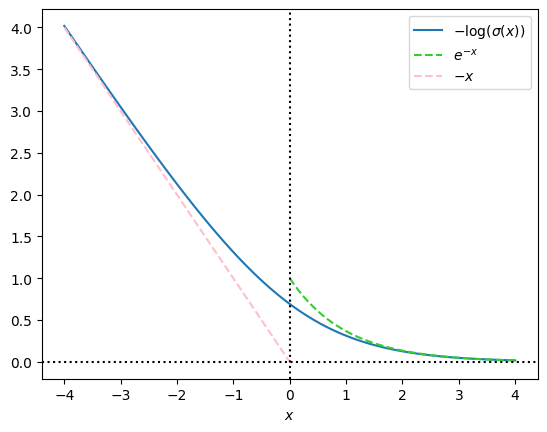

In [26]:
from matplotlib.pyplot import plot,show,xscale,yscale,imshow,legend,colorbar,hist,subplots,scatter,xlabel,ylabel,axvline,axhline
from jax.numpy import linspace,log,exp
def plot_asymptotics(f,f_lab,f_p,f_p_lab,f_n,f_n_lab,sh=True,
                     x=linspace(-4,4,100),xp=linspace(0,4,50),xn=linspace(-4,0,50)):
  plot(x,f(x),label=f_lab)
  plot(xp,f_p(xp),color='limegreen',linestyle='dashed',label=f_p_lab)

  plot(xn,f_n(xn),color='pink',linestyle='dashed',label=f_n_lab)
  xlabel('$x$')
  axvline(c='black',linestyle='dotted')
  axhline(c='black',linestyle='dotted')
  legend()
  if sh:
    show()

phi=lambda t:-log(1/(1+exp(-t)))
phi_p=lambda x:exp(-x)
phi_n=lambda x:-x

plot_asymptotics(phi,'$-\\log(\\sigma(x))$',phi_p,'$e^{-x}$',phi_n,'$-x$')

In [27]:
cost_rats=[1,2,4,8,10,50,100]

## Experiment 0
### Experiment 0.1: BCE on raw data
- Here we train with BCE and measure performance against a range of possible cost ratios
- Want to test effects of common resampling techniques

In [28]:
from matplotlib.pyplot import plot,show,xscale,yscale,imshow,legend,colorbar,hist,subplots,scatter,title
from jax.random import split,key,bits
from time import perf_counter
from collections import namedtuple
from cal.rs import resamplers_list,Resampler

FPFNComplex=namedtuple('FPFNComplex',['cutoff','fp_rate','fn_rate'])

def fp_fn_complex(preds,targs):
  preds=preds.reshape(-1)
  targs=targs.reshape(-1)
  prediction_indices_by_likelihood=argsort(preds)

  targs=targs[prediction_indices_by_likelihood]
    
  d_err_test=(1/len(targs))
  
  fn_rates=cumsum(targs)*d_err_test
  fp_rates=flip(cumsum(flip(~targs)))*d_err_test
  return FPFNComplex(preds[prediction_indices_by_likelihood],fp_rates,fn_rates)

Results=namedtuple('Results',['fpfn_train','fpfn_test','cutoff','res_by_cost_rat'])

def optimal_cutoff(fpfn,cost_ratio):
  i=argmin(fpfn.fp_rate+cost_ratio*fpfn.fn_rate)
  return fpfn.fp_rate[i],fpfn.fn_rate[i],fpfn.cutoff[i]

def get_rates(fpfn,cutoff):
  i=argmax(fpfn.cutoff>cutoff)
  return fpfn.fp_rate[i],fpfn.fn_rate[i]

def results(preds_train,targs_train,preds_test,targs_test,cost_ratios):
  fpfn_train,fpfn_test=fp_fn_complex(preds_train,targs_train),fp_fn_complex(preds_test,targs_test)
  cutoff={}
  expected_cost_test={}
  for cr in cost_ratios:
    fpr,fnr,co=optimal_cutoff(fpfn_train,cr)
    cutoff[cr]=co
    fpr_test,fnr_test=get_rates(fpfn_test,co)
    expected_cost_test[cr]=fpr,fnr,fpr_test,fnr_test,(fpr+cr*fnr)/(cr**.5)
  return Results(fpfn_train,fpfn_test,cutoff,expected_cost_test)

class NN(Module):
  features:Sequence[int]
  
  def setup(self):
    self.layers=[Dense(f) for f in self.features]
    
  def __call__(self,x):
    x=self.layers[0](x)
    for l in self.layers[1:]:
      x=l(relu(x)) # in general no restruction on float output of NN - treat as log relative likelihood
    return x

  
class NNPL:
  #Saving and loading resampled data seems to be causing problems not sure why, bit annoying!
  def __init__(self,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,cost_rats=cost_rats,
               loss=sigmoid_binary_cross_entropy,ds_name='unsw',x_dt=None,y_dt=None,
               rs_dir=None,bs=128,lr=1e-4,features=[128,64,32,1],seed=0,log=print,
               n_epochs=100,loss_param=None,plot_title='NN trained on UNSW'):#[256,128,64,1]
    self.x_train=array(x_train,dtype=x_dt)
    if y_dt is None:
      y_dt=bool #self.x_train.dtype
    self.y_train=array(y_train,dtype=y_dt)
    self.x_test=array(x_test,dtype=x_dt)
    self.y_test=array(y_test,dtype=y_dt)
    self.p=self.y_train.mean()
    self.p_test=self.y_test.mean()
    self.bs=bs
    self.n_epochs=n_epochs
    self.lr=lr
    self.loss=loss
    
    self.key=key(seed)
    self.m=NN(features=features)
    
    self.init_param=self.m.init(self.getk(),self.x_train[0])
    
    self.t=adam(learning_rate=self.lr)
    
    self.init_state=self.t.init(self.init_param)
    
    self.cost_rats=cost_rats
    
    self.state={}
    self.param={}
    self.log=log
    self.ds_name=ds_name
    self.rs_dir=rs_dir
    self.pred_train={}
    self.pred_test={}

    self.epochs_time={}
    self.update_rules={}
    self.res={}
    
    self.plot_title=plot_title
    
    self.rs=Resampler(self.x_train,self.y_train,self.rs_dir,self.ds_name,int(bits(self.getk())))

    
  def updates(self,x_batched,y_batched,rs='',loss_param=None):
    if not loss_param in self.update_rules:
      if loss_param is None:
        loss=self.loss
      else:
        loss=self.loss(loss_param)
      dl=grad(lambda par,feat,targ:loss(self.m.apply(par,feat),targ).sum())

      def update(state_param,x_y):
        state,param=state_param
        x,y=x_y
        g=dl(param,x,y)
        upd,state=self.t.update(g,state)
        param=apply_updates(param,upd)
        return (state,param),0
      self.update_rules[loss_param]=jit(lambda state_param,x_b,y_b:scan(update,state_param,(x_b,y_b))[0])
      
    update_rule=self.update_rules[loss_param]
    y_batched=y_batched.astype(x_batched.dtype)
    self.state[rs,loss_param],self.param[rs,loss_param]=update_rule((self.state[rs,loss_param],
                                                                     self.param[rs,loss_param]),
                                                                    x_batched,y_batched)

  def mk_preds(self,rs='',loss_param=None):
    self.pred_train[rs,loss_param]=self.predict_cts(self.x_train,rs=rs,loss_param=loss_param).reshape(-1)
    self.pred_test[rs,loss_param]=self.predict_cts(self.x_test,rs=rs,loss_param=loss_param).reshape(-1)
    
  def fit(self,rs='',loss_param=None):
    if not rs in self.state:
      self.state[rs,loss_param]=self.init_state
      self.param[rs,loss_param]=self.init_param
    self.epochs(rs=rs,loss_param=loss_param)
    self.results(rs=rs,loss_param=loss_param)

  def epochs(self,rs='',n=None,loss_param=None):
    x,y=self.rs.get_resampled(True,rs)
    self.log('Resampling took',self.rs.get_t(True,rs),'seconds')
    
    if n is None:
      n=self.n_epochs
    t0=perf_counter()
    for e in range(n):
      self.log('Running epoch',e+1,'of',n,'...',end='\r')
      x_batched,y_batched=shuffle_batched(self.getk(),x,y,self.bs)
      self.updates(x_batched,y_batched,rs,loss_param=loss_param)
    self.epochs_time[rs,loss_param]=perf_counter()-t0
    self.log('Completed',n,'epochs in',self.epochs_time[rs,loss_param],'seconds')
    self.log('Getting fp-fn characteristic')
    self.mk_preds(rs=rs,loss_param=loss_param)
    #assert self.pred_train[rs,loss_param].min()<self.pred_train[rs,loss_param].max(),\
    #       'Uh oh:'+str(self.pred_train[rs,loss_param].min())+'=='+str(self.pred_train[rs,loss_param].max())

  def predict_cts(self,x,rs='',loss_param=None):
    if not (rs,loss_param) in self.param:
      self.param[rs,loss_param]=self.init_param
    return self.m.apply(self.param[rs,loss_param],x)
  
  def getk(self):
    self.key,k=split(self.key)
    return k

  def predict_bin(self,x,cost_ratio,rs='',loss_param=None): # NN output is relative likelihood so take log
    pred=self.predict_cts(x,rs=rs,loss_param=loss_param)
    if cutoff_rule=='bayes':
      cutoff=-log(cost_ratio)#inverse_sigmoid(cost_ratio)
    elif cutoff_rule=='optimal':
      cutoff=self.get_optimal_cutoff(cost_ratio)
      
    return pred>cutoff
  
  def results(self,rs='',loss_param=None):
    preds_train=self.predict_cts(self.x_train,rs=rs,loss_param=loss_param)
    preds_test=self.predict_cts(self.x_test,rs=rs,loss_param=loss_param)
    self.res[rs,loss_param]=r=results(preds_train,self.y_train,preds_test,self.y_test,self.cost_rats)
    return r
  
  def report(self,rs='',loss_param=None):
    r=self.res[rs,loss_param]
    just=14
    lj=lambda x:str(x).ljust(just)
    self.log(lj('cost_rat')+lj('fp_train')+lj('fn_train')+\
             lj('fp_test')+lj('fn_test')+lj('E_test(cost)'))
    for cost_ratio,(fp,fn,fp_test,fn_test,c) in r.res_by_cost_rat.items():
      s=lj(str(cost_ratio))
      s+=lj(fp)+lj(fn)
      s+=lj(fp_test)+lj(fn_test)
      s+=lj(c)
      print(s)
  
  def plot(self,rs='',loss_param=None):
    show()
    r=self.res[rs,loss_param]
    plot(r.fpfn_train.fp_rate,r.fpfn_train.fn_rate)
    plot([0,1-self.p],[self.p,0])
    title(self.plot_title+' '+rs+' '+str(loss_param))
    xlabel('False positives')
    ylabel('False negatives')
    show()
    print(r.fpfn_train)
    print(r.fpfn_train.cutoff)

    hist(r.fpfn_train.cutoff,label='Raw NN outputs',bins=100)


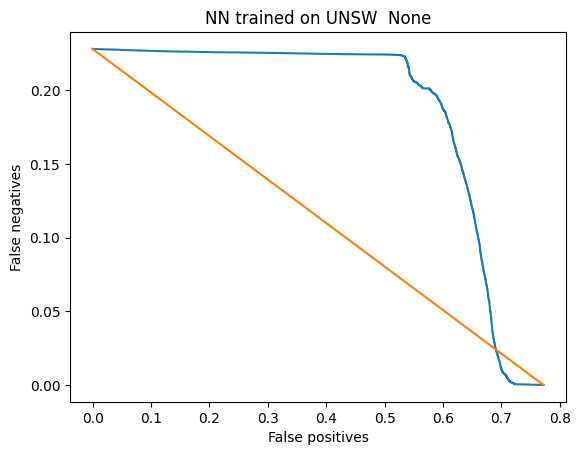

FPFNComplex(cutoff=Array([-2.1456316, -1.9680783, -1.9680783, ...,  2.717459 ,  2.7650661,
        3.004786 ], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-2.1456316 -1.9680783 -1.9680783 ...  2.717459   2.7650661  3.004786 ]


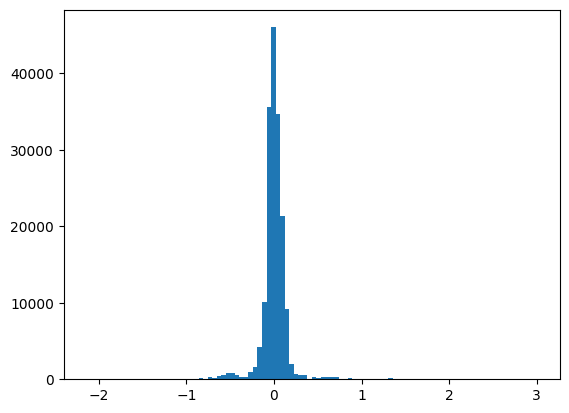

In [29]:
nn_bce=NNPL()

nn_bce.mk_preds()
nn_bce.results()
nn_bce.plot()

Resampling took 0 seconds
Completed 100 epochs in 11.551675810000233 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.020981971   0.009107967   0.018328233   0.063134626   0.030089937   
2             0.023702385   0.007043418   0.020745276   0.043737553   0.026721014   
4             0.024632001   0.0066327895  0.021656223   0.0390978     0.02558158    
8             0.03142448    0.0054750456  0.026429579   0.016081233   0.026595999   
10            0.03142448    0.0054750456  0.026429579   0.016081233   0.027250906   
50            0.045494206   0.004762149   0.03793179    0.009631735   0.040107332   
100           0.1425679     0.0036557335  0.13433416    0.0059393677  0.05081413    


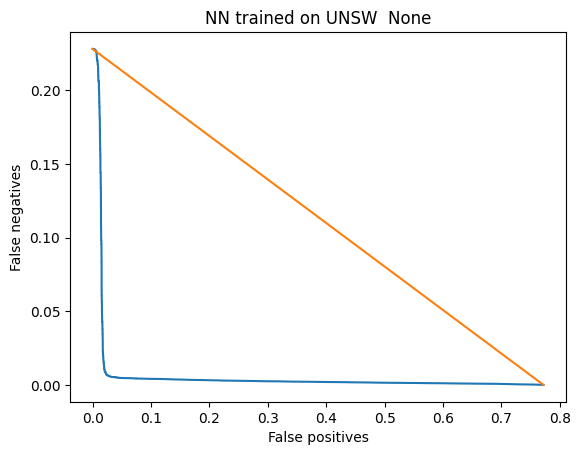

FPFNComplex(cutoff=Array([-1.583798 , -1.5255886, -1.5008668, ..., -1.0604033, -1.0422506,
       -0.9823097], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-1.583798  -1.5255886 -1.5008668 ... -1.0604033 -1.0422506 -0.9823097]


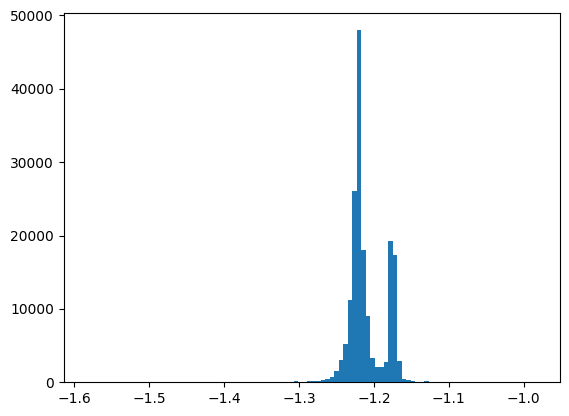

In [30]:
nn_bce.fit()
nn_bce.report()
nn_bce.plot()

- Not well calibrated (Bayes rule for threshold is useless) but not a problem really

### Experiment 0.2: Effects of resampling schemes on BCE
$\newcommand\rs{\texttt{rs}}$
- Common to try using various resampling schemes during training
- Such a scheme takes dataset $D=(x^{(i)},y^{(i)})$ and transforms it to $D_\rs=(x_\rs^{(i)},y_\rs^{(i)})$
- Idea: address issues that arise from imbalance (note this framing is contentious in literature, with some taking a view that particularly hard problems described in this way may be better understood as a problem of limited data)

In [31]:
print(resamplers_list)

['NearMiss', 'SMOTEENN', 'ADASYN', 'SMOTE', 'SMOTETomek', '']


#### Cost loss?
- Probablistically BCE loss analogous to learning likelihoods over wide range - use cases include high uncertainty in future costs
- Fixing costs is in a sense at other extreme of possible approaches - all we care about is whether likelihoods are above a set threshold
- Costs $\chi_\pm$ for false negatives and false positives have an associated loss with constant gradient with respect to $\tilde y$ for fixed $y'\in\{\pm\}$,
$$
C_\chi(\tilde y,y)=\chi_+1_{y=+}(1-\tilde y)+\chi_-1_{y=-}\tilde y
$$
so that gradients in the direction of the correct label are scaled by some notion of importance of each class.
When reframed as a function of the density this becomes
$$
\widetilde C_\chi(\rho,y)=\chi_+1_{y=+}\sigma(-\rho)+\chi_-1_{y=-}\sigma(\rho)
$$

Resampling data with method NearMiss ...
NearMiss doesn't take a random seed...
Resampling took 8.3319052869997 seconds
Completed 100 epochs in 6.0200862299998334 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             5.7031725e-06 0.2281269     0.0001821892  0.22920614    0.2281326     
2             0.37201223    0.005258325   0.39164603    0.009765341   0.27048877    
4             0.373957      0.004534022   0.3933829     0.007518341   0.19604655    
8             0.38535768    0.0024637706  0.40396202    0.0048340866  0.14321311    
10            0.38535768    0.0024637706  0.40396202    0.0048340866  0.12965192    
50            0.38877958    0.0023440039  0.4080066     0.0046033137  0.07155635    
100           0.3934961     0.0022869722  0.41202694    0.004287519   0.062219333   


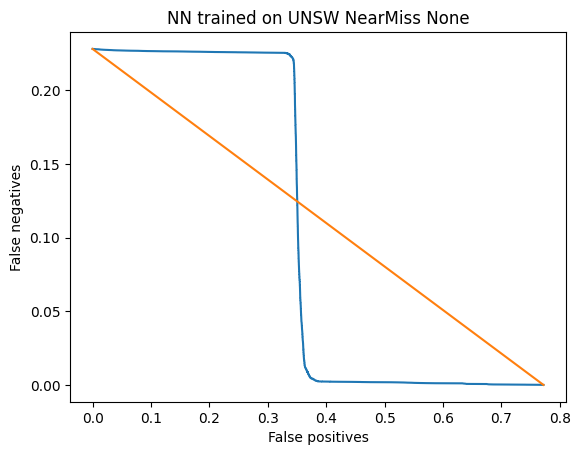

FPFNComplex(cutoff=Array([-0.20712227, -0.19708468, -0.18631852, ...,  0.20005256,
        0.20005256,  0.20005256], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.1406345e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-0.20712227 -0.19708468 -0.18631852 ...  0.20005256  0.20005256
  0.20005256]
Resampling data with method SMOTEENN ...
Resampling took 114.72658928300007 seconds
Completed 100 epochs in 18.73331053400034 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             6.27349e-05   0.005161371   4.8583785e-05 0.0090244375  0.005224106   
2             0.000165392   0.0050701206  9.716757e-05  0.008732935   0.007287183   
4             0.000165392   0.0050701206  9.716757e-05  0.008732935   0.010222937   
8        

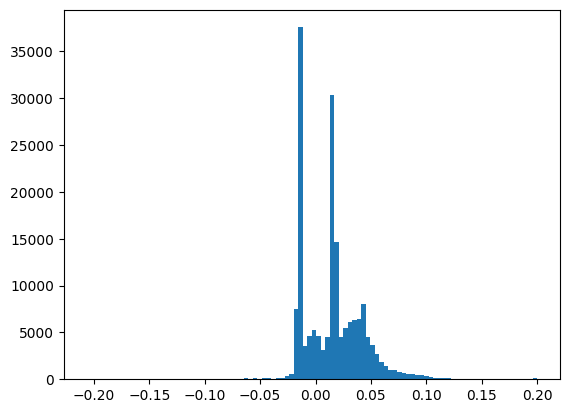

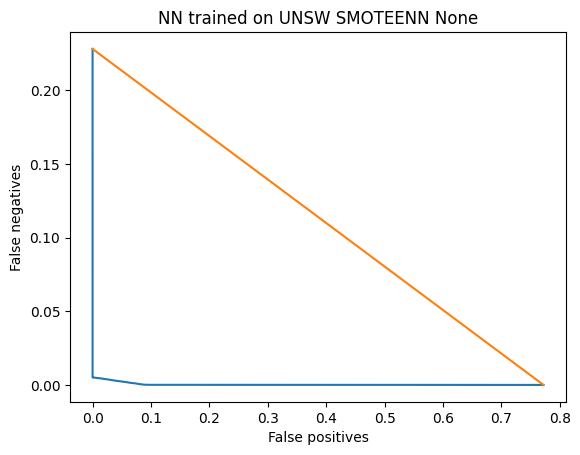

FPFNComplex(cutoff=Array([-0.02688551, -0.02576053, -0.02387922, ...,  0.01720317,
        0.01722946,  0.01739917], dtype=float32), fp_rate=Array([0.77187306, 0.7718674 , 0.7718617 , ..., 0.        , 0.        ,
       0.        ], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.2281155 , 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-0.02688551 -0.02576053 -0.02387922 ...  0.01720317  0.01722946
  0.01739917]
Resampling data with method ADASYN ...
Resampling took 13.00758351100012 seconds
Completed 100 epochs in 19.070248226999865 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0037070622  0.004899025   0.0028664432  0.029320315   0.008606087   
2             0.0042089415  0.0046138666  0.0032429677  0.020125832   0.009501164   
4             0.0047108205  0.004425662   0.0035952001  0.013324103   0.011206735   
8             0.0047108

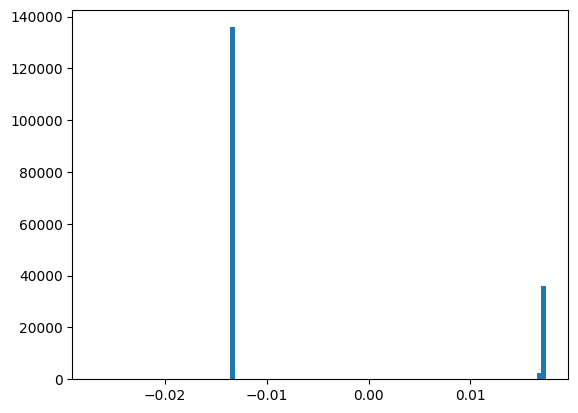

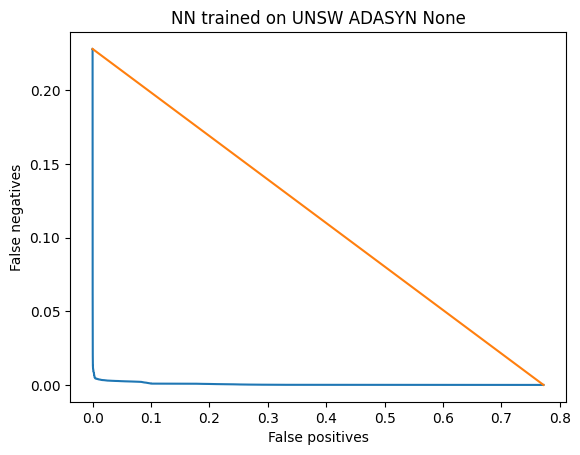

FPFNComplex(cutoff=Array([-0.03294569, -0.03275556, -0.0326893 , ...,  0.03095335,
        0.04172862,  0.04479466], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-0.03294569 -0.03275556 -0.0326893  ...  0.03095335  0.04172862
  0.04479466]
Resampling data with method SMOTE ...
Resampling took 2.5685913700003766 seconds
Completed 100 epochs in 18.932092474 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.00019390786 0.0051157456  9.716757e-05  0.0090973135  0.0053096535  
2             0.00019390786 0.0051157456  9.716757e-05  0.0090973135  0.0073718703  
4             0.00031367448 0.005058714   0.00014575136 0.008732935   0.010274266   
8             0.0

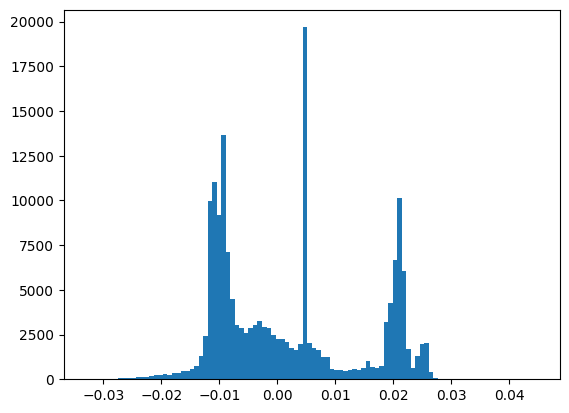

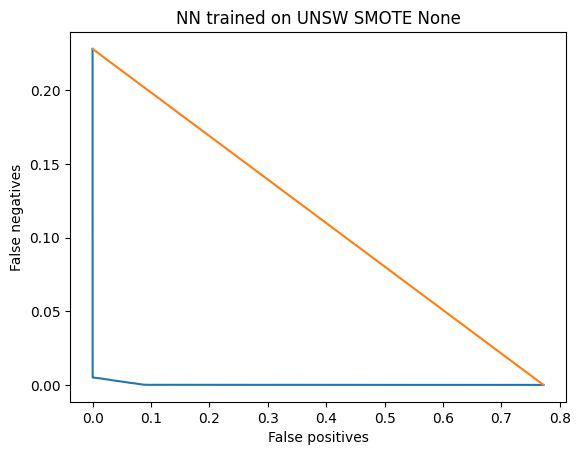

FPFNComplex(cutoff=Array([-0.01759236, -0.01759012, -0.01755141, ...,  0.01673241,
        0.01673241,  0.01673241], dtype=float32), fp_rate=Array([0.77187306, 0.7718674 , 0.7718617 , ..., 0.        , 0.        ,
       0.        ], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.2281155 , 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-0.01759236 -0.01759012 -0.01755141 ...  0.01673241  0.01673241
  0.01673241]
Resampling data with method SMOTETomek ...
Resampling took 114.37128490399982 seconds
Completed 100 epochs in 18.99165371700019 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             6.27349e-05   0.005161371   2.4291892e-05 0.011514357   0.005224106   
2             8.554759e-05  0.0051499647  3.643784e-05  0.011259292   0.007343641   
4             0.00019390786 0.0050986363  0.00013360541 0.010469805   0.010294226   
8             0.000

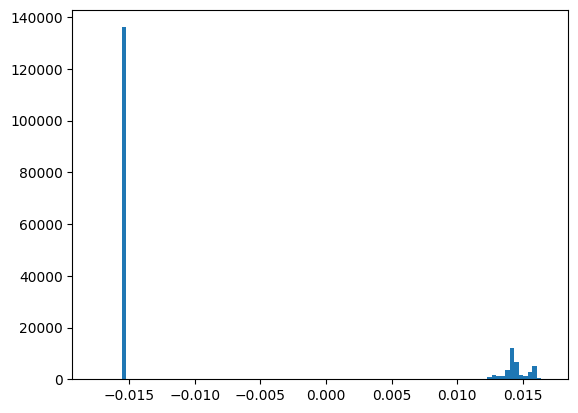

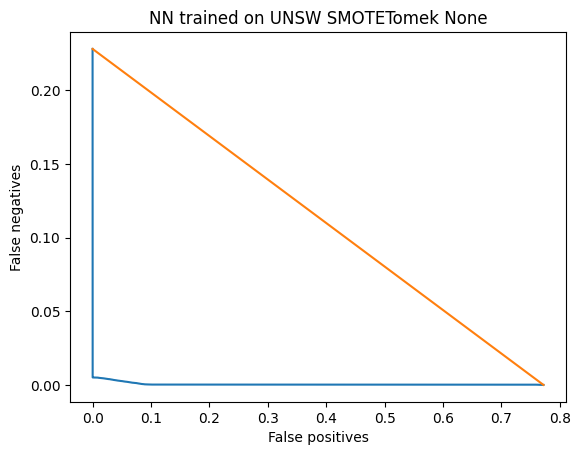

FPFNComplex(cutoff=Array([-0.02236995, -0.02236995, -0.02236995, ...,  0.01406304,
        0.01451338,  0.01554429], dtype=float32), fp_rate=Array([0.77187306, 0.7718674 , 0.7718617 , ..., 0.        , 0.        ,
       0.        ], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.2281155 , 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-0.02236995 -0.02236995 -0.02236995 ...  0.01406304  0.01451338
  0.01554429]
Resampling took 0 seconds
Completed 100 epochs in 10.942427445999783 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.045237564   0.008229678   0.03895205    0.070264295   0.05346724    
2             0.045688115   0.007984442   0.039437886   0.06611039    0.04359808    
4             0.051174566   0.0058001266  0.042717293   0.020696692   0.037187535   
8             0.054014746   0.0051100426  0.044891417   0.013311957   0.033550

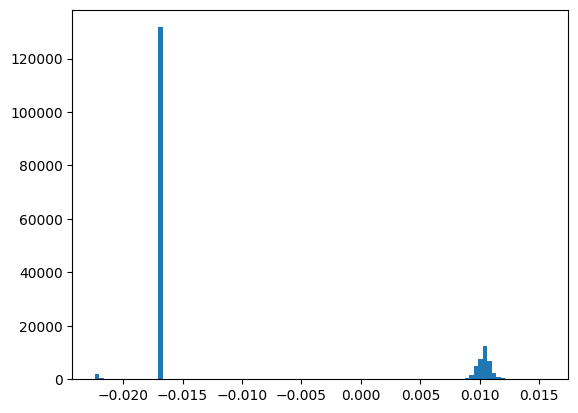

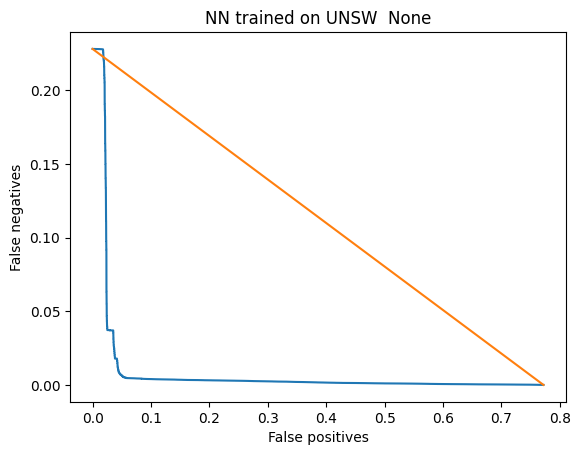

FPFNComplex(cutoff=Array([-1.7370275 , -1.671949  , -1.5937941 , ..., -0.9740167 ,
       -0.9714301 , -0.97067803], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-1.7370275  -1.671949   -1.5937941  ... -0.9740167  -0.9714301
 -0.97067803]


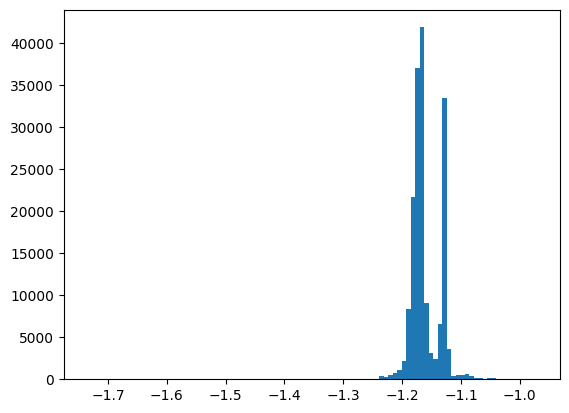

In [32]:
#nns={}
for rs in resamplers_list:
  #nn=NNPL(x_train,y_train,x_test,y_test,sigmoid_binary_cross_entropy,'unsw')
  nn_bce.fit(rs=rs)
  nn_bce.report(rs=rs)
  nn_bce.plot(rs=rs)
  #nns[rs]=nn

In [33]:
'''
### Experiment 0.2: Cost
def mk_cost(cr):
  def cost(pred,targ):
    return cr*targ*sigmoid(-pred)+(1-targ)*sigmoid(pred)
  return jit(cost)

print('Training on cost...')
for cr in cost_rats+[200,400]:
  nn=NNPL(x_train,y_train,x_test,y_test,mk_cost(cr))
  nn.epochs()
  nn.report(cost_rats)
  nn.plot('NN trained on UNSW with cost for ratio '+str(cr))'''


"\n### Experiment 0.2: Cost\ndef mk_cost(cr):\n  def cost(pred,targ):\n    return cr*targ*sigmoid(-pred)+(1-targ)*sigmoid(pred)\n  return jit(cost)\n\nprint('Training on cost...')\nfor cr in cost_rats+[200,400]:\n  nn=NNPL(x_train,y_train,x_test,y_test,mk_cost(cr))\n  nn.epochs()\n  nn.report(cost_rats)\n  nn.plot('NN trained on UNSW with cost for ratio '+str(cr))"

# General classifier losses as weighted sums of costs
- At a glance seems cost may be useless - but any loss of interest can be written as a sum of all possible costs



## Expected misclassification cost 
In a random formulation eg per https://link.springer.com/article/10.1007/s10994-024-06634-8 we seek to minimise $c$ in expectation:
$\newcommand\dee{\mathrm{d}}$
$$
\mathbb E(c)=\int_{\Sigma\times\mathcal X\times\mathcal Y} C_\sigma(y',\hat y_{\sigma'}(x'))\dee\mathbb P(\sigma',x',y')
$$
Try their losses - but might be the case that most important aspect of analysis is asymptotic behaviour of losses


### Beta losses

- Authors let positive and negative costs be gamma RVs with parameters $(\alpha,\theta)$ and and obtain an expected misclassification cost proportional to
\begin{align*}
L_{\alpha\beta}(\tilde y,y)=&\int_0^{\tilde y}(t-y)t^{\alpha-1}(1-t)^{\beta-1}\dee t\\
=&\begin{cases} -\int_0^{\tilde y}t^{\alpha-1}(1-t)^\beta\dee t\text{ if }y=+,\\
\int_0^{\tilde y}t^\alpha(1-t)^{\beta-1}\dee t\text{ otherwise}\end{cases}\\
=&B(\alpha+(1-y),\beta+y;\tilde y)\\
=&B(a,b,\tilde y)\text{ for convenience}
\end{align*}
- $B$ is well known - the (incomplete) beta function 


### Loss asymptotics II: Beta loss at high certainties
- $a$ and $b$ describe the asymptotic order of $B(a,b,t)$ for $t\approx0$ and $t\approx 1$ respectively
- Specifically can check that
$$
B(a,b,t)\sim\begin{cases}O\left(\begin{cases}t^a\text{ if }a>0\\\log(t)\text{ if }a=0\end{cases}\right)\text{ when }0\approx t\ll1,\\O\left(\begin{cases}(1-t)^b\text{ if }b>0\\\log(1-t)\text{ if }b=0\end{cases}\right)\text{ when }0\ll t\approx1\end{cases}
$$


- This behaviour is mirrored in the log likelihood picture, where
$$
\widetilde B(a,b,\rho)\sim\begin{cases}
O\left(\begin{cases}
e^{\rho a}\text{ if }a>0\\
\rho\text{ if }a=0
\end{cases}\right)\text{ when }\rho\ll0,\\
O\left(\begin{cases}
e^{-\rho b}\text{ if }b>0\\
-\rho\text{ if }b=0
\end{cases}\right)\text{ when }\rho\gg0
\end{cases}
$$

- which means that
$$
\widetilde L_{\alpha\beta}(\rho,+)=\tilde B(\alpha,\beta+1;\rho)\sim
\begin{cases}
O(-e^{\rho\alpha})\text{ if }\alpha>0,~y=+\text{ and }\rho\ll0\\
O(-\rho)\text{ if }\alpha=0,~y=+\text{ and }\rho\ll0\\
O(e^{\rho(\beta+1)})\text{ if }~y=+\text{ and }\rho\gg0\\
\end{cases}
$$

- The parameters $\alpha$ and $\beta$ are not directly related to any single value of cost and should be taken to describe the tail risk associated with each type of error
- This is in line with the consequences of different decisions eg in the case of cybersecurity - legitimate traffic on a network being blocked may cause serious problems in the short term, but doesn't typically have the risks associated with malicious actors being able to access a network.

### Loss asymptotics III: Beta loss for small $\alpha$ and $\beta$ as perturbations of BCE
- From above discussion view $\alpha$ and $\beta$ as controlling the cost uncertainty for false negative and false positive
- Need each of $a$ and $b$ in the above expression to be nonnegative, whence it is necessary that $(\alpha,\beta)\in[0,\infty)^2$
- Can check by substitution that $B(a,b;c)=B(b,a,1-c)$ and $B(-1,0;\tilde y)=\log\tilde y$
- It follows that $L_{00}=\SBCE$
- If $\alpha$ and $\beta$ are small this is a parameterised perturbation of the BCE - in order for the loss to be well defined both $\alpha$ and $\beta$ must be nonnegative so the BCE can be seen is a limit as uncertainty in the positive and negative costs diverges
- Initially fix $\alpha$ and try small values of $\beta$ - this corresponds to assuming increasingly thin tails on the uncertainty in the cost of a false positive

### Numerical instability for provided beta functions
- Naively trying out this map doesn't go well
- doesn't seem particularly numerically stable over range of interest, so this is unsurprising
- Could just write down a desired gradient directly or choose another perturbation of BCE in the direction of higher cost certainty - we will do the latter

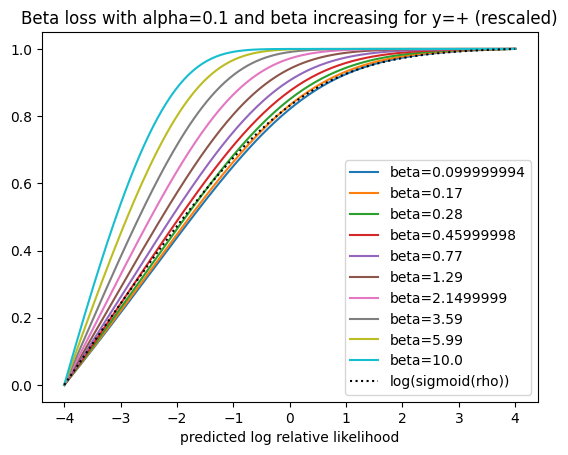

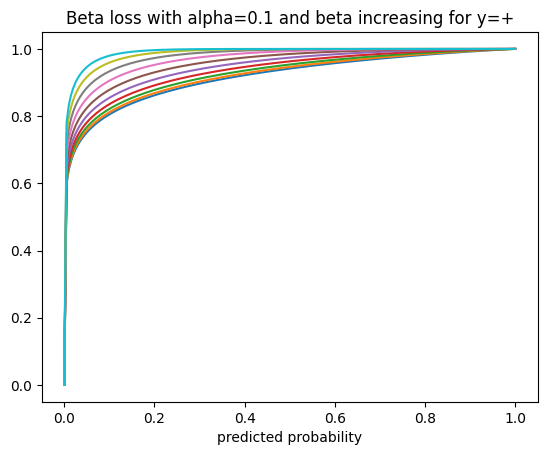

In [34]:
# For now, just use $\alpha=10^{-1}$ and scale $\beta$ - should investigate numerical stability further though...
from jax.scipy.special import betainc
from jax.scipy.stats.beta import cdf
from jax.numpy import geomspace
Ir=linspace(-4,4,200)
betas=geomspace(.1,10,10)
alpha_small=.1
for b in betas:
  
  l=cdf(sigmoid(Ir),alpha_small,b+1)
  l/=(l.max()-l.min())
  l-=l.min()
  plot(Ir,l,label='beta='+str(round(100*b)/100))
l=log(sigmoid(Ir))
l/=(l.max()-l.min())
l-=l.min()
plot(Ir,l,label='log(sigmoid(rho))',c='black',linestyle='dotted')
xlabel('predicted log relative likelihood')
title('Beta loss with alpha='+str(alpha_small)+' and beta increasing for y=+ (rescaled)')
legend()
show()

Ip=linspace(0,1,200)
for b in betas:
  l=cdf(Ip,alpha_small,b+1)
  plot(Ip,l,label='beta='+str(round(100*b)/100))

title('Beta loss with alpha='+str(alpha_small)+' and beta increasing for y=+')

xlabel('predicted probability')
show()

def mk_fp_relaxed_beta_loss(beta,alpha_small=alpha_small):
  def beta_loss(pred,targ):
    return betainc(alpha_small+1-targ,beta+targ,sigmoid(pred))
  
  return jit(beta_loss)
    

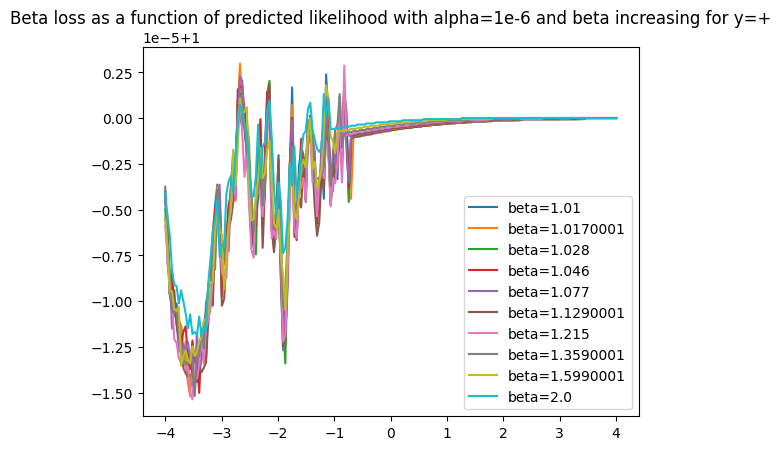

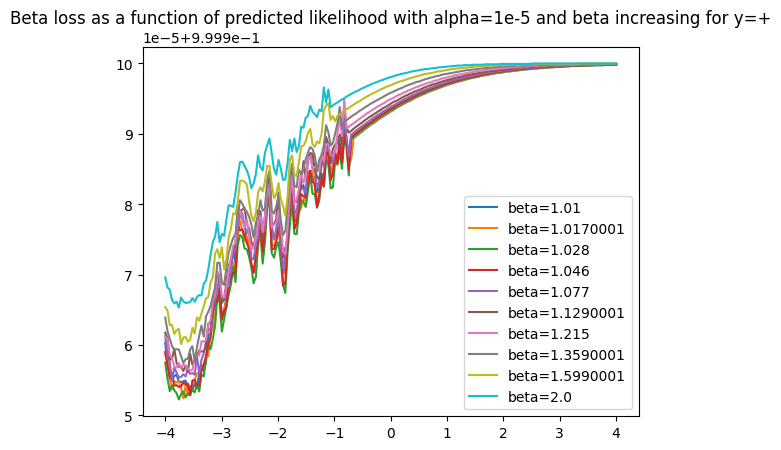

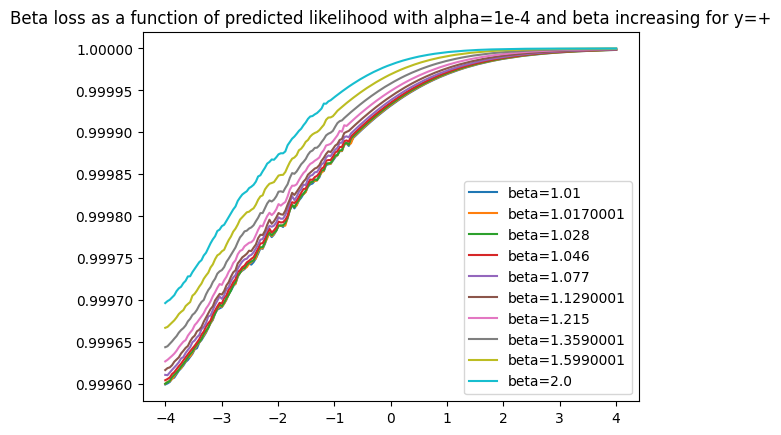

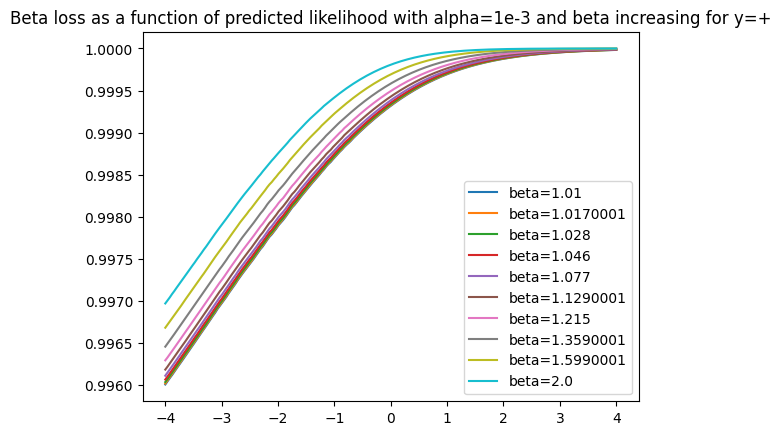

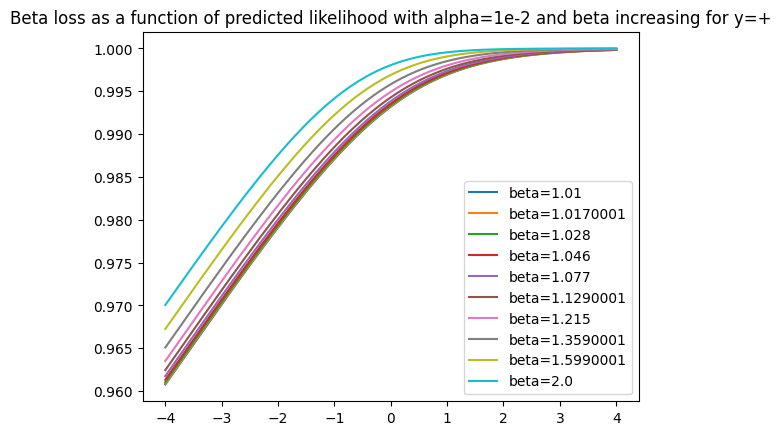

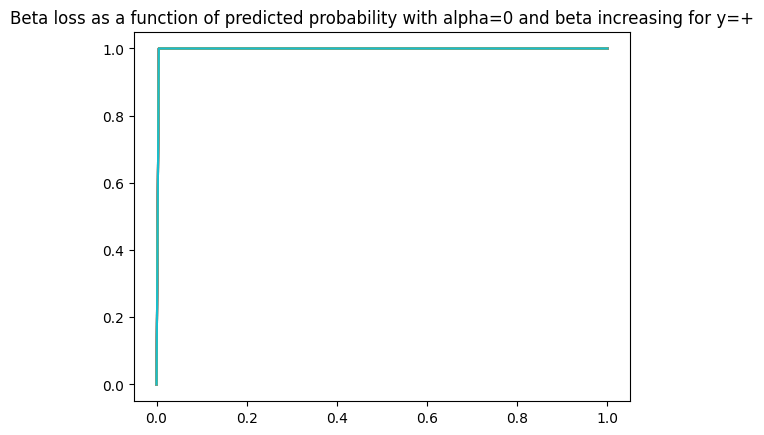

In [35]:

Ir=linspace(-4,4,200)
betas=1.+geomspace(.01,1,10)
for a in [1e-6,1e-5,1e-4,1e-3,1e-2]:
  for b in betas:
    plot(Ir,betainc(a,b,sigmoid(Ir)),label='beta='+str(round(1000*b)/1000))
  title('Beta loss as a function of predicted likelihood with alpha=1e'+str(round(log(a)/log(10)))+\
        ' and beta increasing for y=+')
  legend()
  show()

Ip=linspace(0,1,200)
for b in betas:
  plot(Ip,betainc(0,b,Ip))
title('Beta loss as a function of predicted probability with alpha=0 and beta increasing for y=+')
show()


- Still seems pretty bad - and get nans upon training


In [36]:
nn_beta=NNPL(loss=mk_fp_relaxed_beta_loss)
beta_small=1e-5
beta_large=1
'''for beta in geomspace(beta_large,beta_small,10):
  nn_beta.fit(loss_param=float(beta))
  nn_beta.report(loss_param=float(beta))
  nn_beta.plot(loss_param=float(beta))'''

'for beta in geomspace(beta_large,beta_small,10):\n  nn_beta.fit(loss_param=float(beta))\n  nn_beta.report(loss_param=float(beta))\n  nn_beta.plot(loss_param=float(beta))'

### Loss asymptotics III: a simple modification
- The core of the idea behind the loss proposed by https://link.springer.com/article/10.1007/s10994-024-06634-8 is that different loss choices relate to different cost uncertainties - higher $\alpha$ and $\beta$ values correspond to thinner tails on cost
- as a simple in silico alternative, we modify binary cross entropy by exponentiating $\sigma(\rho)$ rather than taking logarithms when $y$ is $\boldsymbol -$, which corresponds to lower tail risk associated with false positives
$$
L_{\theta}(\rho,y)=\begin{cases}-\log(\sigma(\rho))\text{ if }y=\boldsymbol+,\\\theta^{-1}(\sigma(\rho))^\theta\text{ otherwise}\end{cases}
$$

In [37]:
def mk_fp_relaxed_bce(beta):
  def beta_loss(pred,targ):
    return -targ*log(sigmoid(pred))+(1-targ)*sigmoid(pred*beta)/beta
  
  return beta_loss

Resampling took 0 seconds
Completed 100 epochs in 11.663685539000198 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.009056638   0.005760204   0.008283535   0.015534665   0.014816842   
2             0.009530001   0.005492155   0.008975854   0.0137977945  0.014505808   
4             0.009997661   0.005332466   0.009255211   0.0116844     0.015663764   
8             0.011166812   0.005155668   0.009643882   0.010372638   0.018530495   
10            0.012700966   0.0049788696  0.010822038   0.0092066275  0.019760964   
50            0.015295909   0.0048762127  0.013287665   0.008550746   0.0366432     
100           0.033591688   0.0046708984  0.028057136   0.008137784   0.05006815    


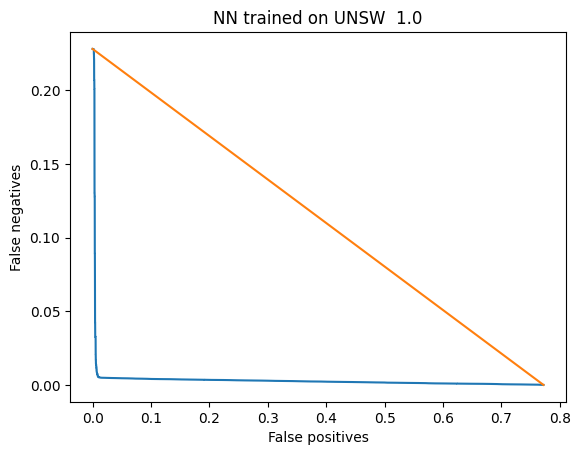

FPFNComplex(cutoff=Array([-1.31822   , -1.3052236 , -1.2695745 , ..., -0.73192894,
       -0.73147   , -0.72913945], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 5.7031725e-06,
       5.7031725e-06, 0.0000000e+00], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.22812119, 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-1.31822    -1.3052236  -1.2695745  ... -0.73192894 -0.73147
 -0.72913945]
Resampling took 0 seconds
Completed 100 epochs in 11.582505331999982 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0027888513  0.005954112   0.0032794054  0.019069135   0.008742963   
2             0.0035644828  0.0054636393  0.004081038   0.014380801   0.010247222   
4             0.0040378463  0.0052355123  0.0042146435  0.012631784   0.0124899475  
8             0.004220348   0.0052126995  0.004323957   0.01184

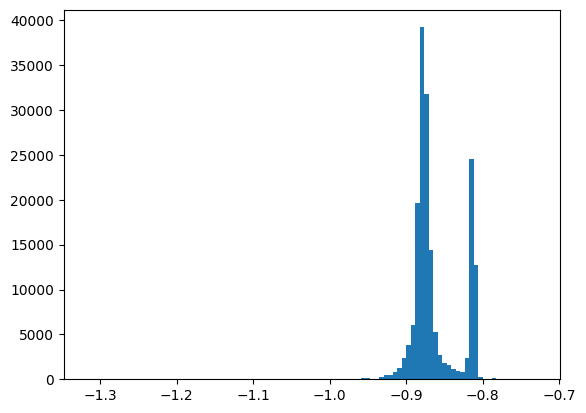

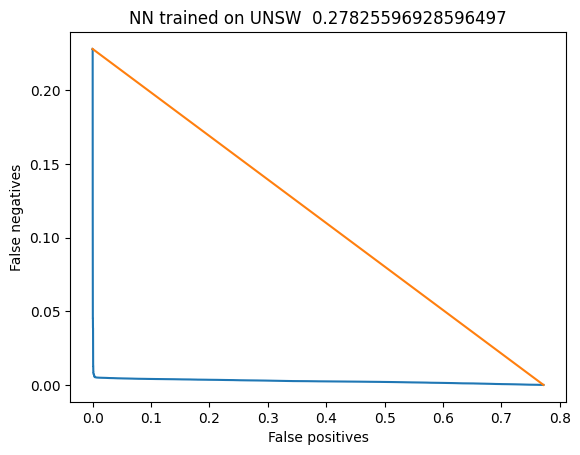

FPFNComplex(cutoff=Array([-2.1023376, -2.0941043, -2.0933874, ..., -1.1078256, -1.098716 ,
       -1.098716 ], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.1406345e-05,
       5.7031725e-06, 0.0000000e+00], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.22812119, 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-2.1023376 -2.0941043 -2.0933874 ... -1.1078256 -1.098716  -1.098716 ]
Resampling took 0 seconds
Completed 100 epochs in 11.591679457000282 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0044769906  0.0066670086  0.0046397513  0.0410533     0.011143999   
2             0.006347631   0.0054351236  0.00680173    0.012984016   0.012174878   
4             0.006347631   0.0054351236  0.00680173    0.012984016   0.014044063   
8             0.007927409   0.0051328554  0.0077491137  0.010955644   0.0

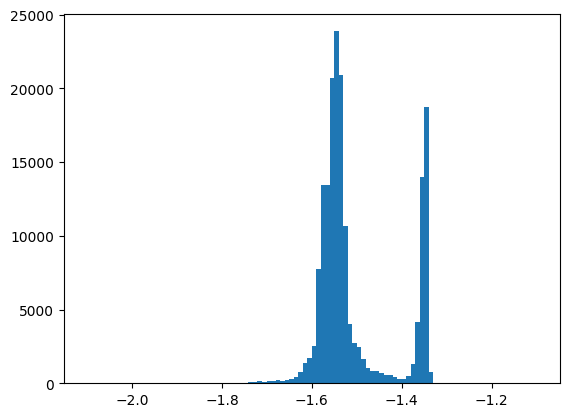

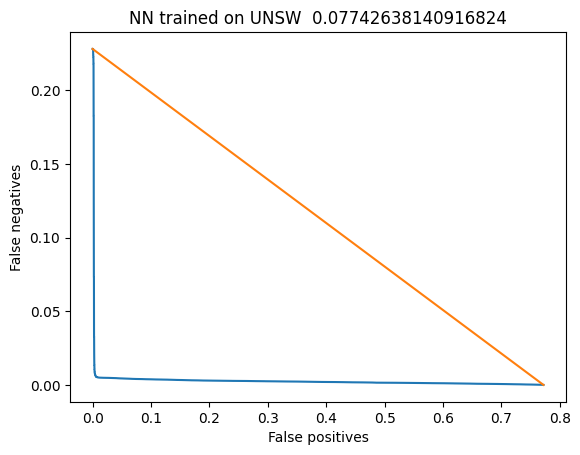

FPFNComplex(cutoff=Array([-2.2711005, -2.2711005, -2.2711005, ..., -1.3267678, -1.2806419,
       -1.278161 ], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-2.2711005 -2.2711005 -2.2711005 ... -1.3267678 -1.2806419 -1.278161 ]
Resampling took 0 seconds
Completed 100 epochs in 11.57946937800034 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.004328708   0.005492155   0.004506146   0.014477968   0.009820864   
2             0.004591054   0.0053381696  0.0046518976  0.011732984   0.010795677   
4             0.005646141   0.0050701206  0.0055142595  0.009388817   0.012963312   
8             0.005646141   0.0050701206  0.0055142595  0.009388817   0.01633667

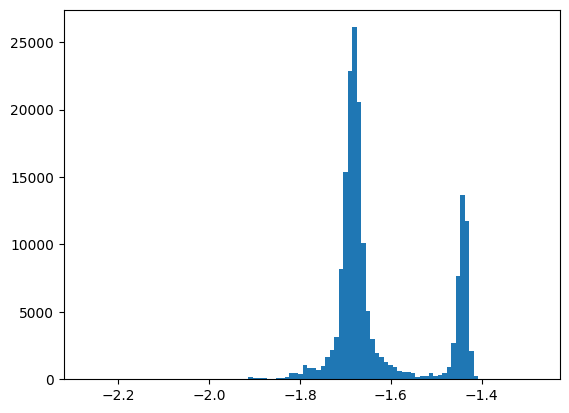

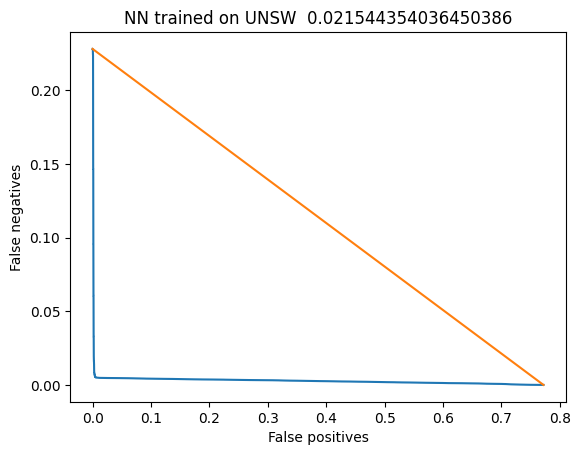

FPFNComplex(cutoff=Array([-1.9219764, -1.9197195, -1.9197195, ..., -1.1661446, -1.1536908,
       -1.1536908], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 5.7031725e-06,
       5.7031725e-06, 0.0000000e+00], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.22812119, 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-1.9219764 -1.9197195 -1.9197195 ... -1.1661446 -1.1536908 -1.1536908]
Resampling took 0 seconds
Completed 100 epochs in 11.844376163000106 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0032793242  0.005389498   0.0031458     0.013263374   0.008668822   
2             0.00330784    0.0053723883  0.003182238   0.012813973   0.009936701   
4             0.003929486   0.005081527   0.0036559298  0.010056843   0.012127797   
8             0.003929486   0.005081527   0.0036559298  0.010056843   0.0

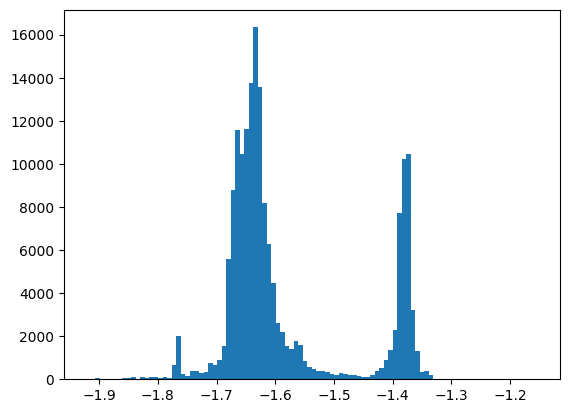

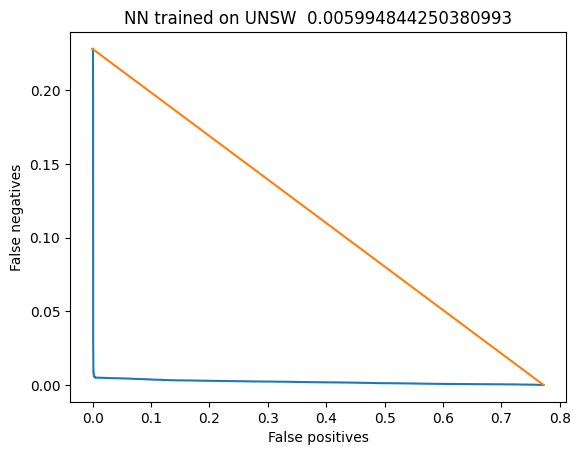

FPFNComplex(cutoff=Array([-2.4840062, -2.4171162, -2.3403134, ..., -1.2862366, -1.2663387,
       -1.266286 ], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 5.7031725e-06,
       5.7031725e-06, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.22812119, 0.2281269 ,
       0.2281269 ], dtype=float32, weak_type=True))
[-2.4840062 -2.4171162 -2.3403134 ... -1.2862366 -1.2663387 -1.266286 ]
Resampling took 0 seconds
Completed 100 epochs in 11.581182712999635 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0025093958  0.0055377805  0.002927173   0.014259341   0.0080471765  
2             0.0029200243  0.0052868407  0.0031458     0.01141719    0.00954149    
4             0.0034276068  0.0051328554  0.0034494486  0.009959675   0.011979514   
8             0.0040435493  0.005030198   0.004238935   0.008708644   0.0

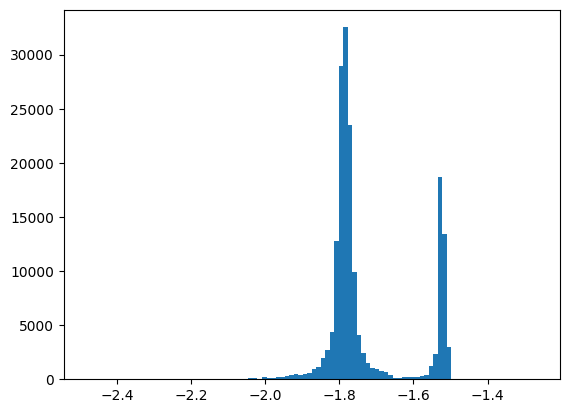

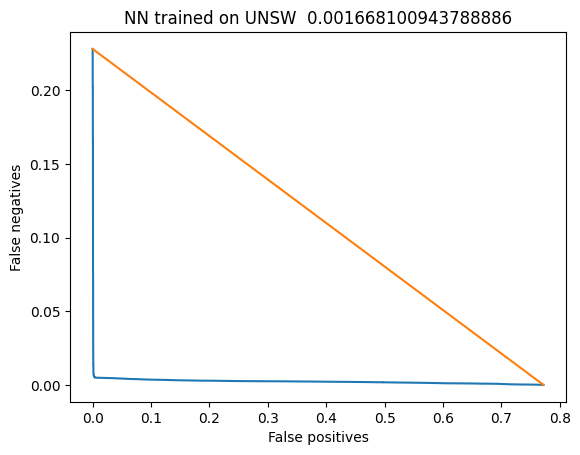

FPFNComplex(cutoff=Array([-1.9818114, -1.9756992, -1.9711041, ..., -1.1398777, -1.1315387,
       -1.1161913], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 5.7031725e-06,
       5.7031725e-06, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.22812119, 0.2281269 ,
       0.2281269 ], dtype=float32, weak_type=True))
[-1.9818114 -1.9756992 -1.9711041 ... -1.1398777 -1.1315387 -1.1161913]
Resampling took 0 seconds
Completed 100 epochs in 11.592887066000003 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0069578704  0.0070662308  0.008902978   0.04401691    0.014024101   
2             0.010037583   0.00532106    0.011526503   0.012984016   0.014622758   
4             0.010037583   0.00532106    0.011526503   0.012984016   0.015660912   
8             0.0111611085  0.0051442618  0.012558908   0.010894913   0.0

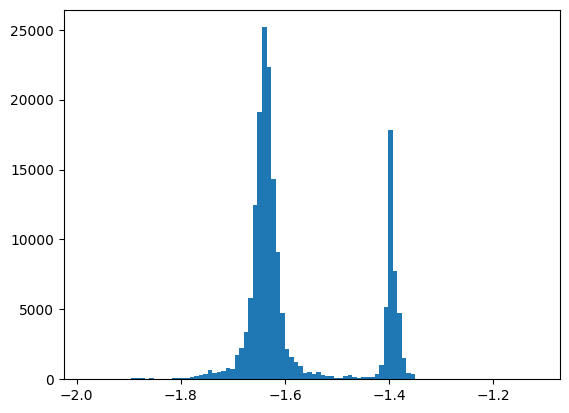

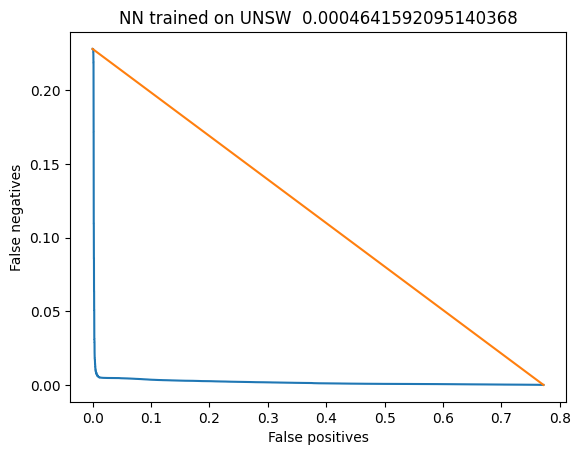

FPFNComplex(cutoff=Array([-2.2958205 , -2.1902425 , -2.0991538 , ..., -0.91150975,
       -0.87115633, -0.8301454 ], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-2.2958205  -2.1902425  -2.0991538  ... -0.91150975 -0.87115633
 -0.8301454 ]
Resampling took 0 seconds
Completed 100 epochs in 11.589954704999855 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0014371994  0.0057259854  0.0020891028  0.016980033   0.0071631847  
2             0.0019219691  0.005452233   0.002453481   0.013761357   0.009069659   
4             0.0031196354  0.0050701206  0.003400865   0.008672206   0.011700058   
8             0.0035359669  0.004995979   0.0037895353  0.00861147

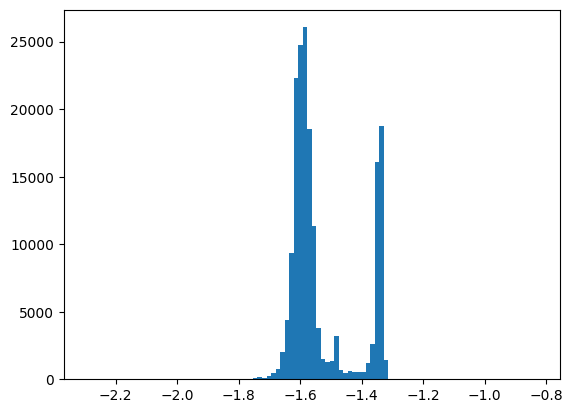

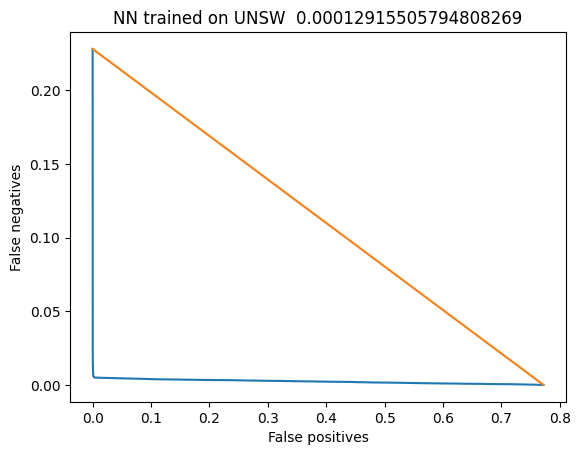

FPFNComplex(cutoff=Array([-2.424045  , -2.332577  , -2.264542  , ..., -1.0709635 ,
       -1.0709635 , -0.87484044], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-2.424045   -2.332577   -2.264542   ... -1.0709635  -1.0709635
 -0.87484044]
Resampling took 0 seconds
Completed 100 epochs in 11.597352328000397 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0043857396  0.00710045    0.005574989   0.06334111    0.011486189   
2             0.0059655183  0.006153723   0.007518341   0.02900452    0.012920937   
4             0.0070548244  0.00578872    0.008951562   0.0188748     0.015104853   
8             0.01040829    0.005127152   0.0106884325  0.009850362

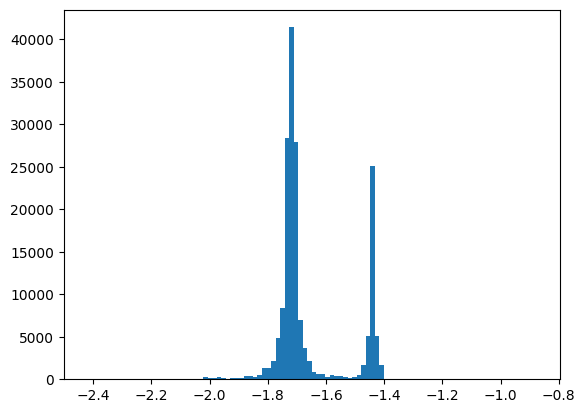

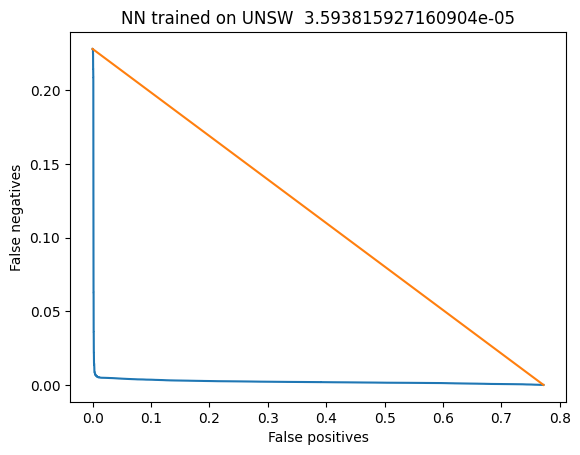

FPFNComplex(cutoff=Array([-2.474788 , -2.366995 , -2.26414  , ..., -1.2323378, -1.1975516,
       -1.1975516], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.7109518e-05,
       1.1406345e-05, 5.7031725e-06], dtype=float32, weak_type=True), fn_rate=Array([0.       , 0.       , 0.       , ..., 0.2281269, 0.2281269,
       0.2281269], dtype=float32, weak_type=True))
[-2.474788  -2.366995  -2.26414   ... -1.2323378 -1.1975516 -1.1975516]
Resampling took 0 seconds
Completed 100 epochs in 11.55822076100003 seconds
Getting fp-fn characteristic
cost_rat      fp_train      fn_train      fp_test       fn_test       E_test(cost)  
1             0.0026861941  0.005640438   0.0034858866  0.01636059    0.008326632   
2             0.003039791   0.005423717   0.0035101785  0.014356508   0.009819752   
4             0.0041804253  0.0050758235  0.0047126273  0.009315941   0.01224186    
8             0.0041804253  0.0050758235  0.0047126273  0.009315941   0.0158346 

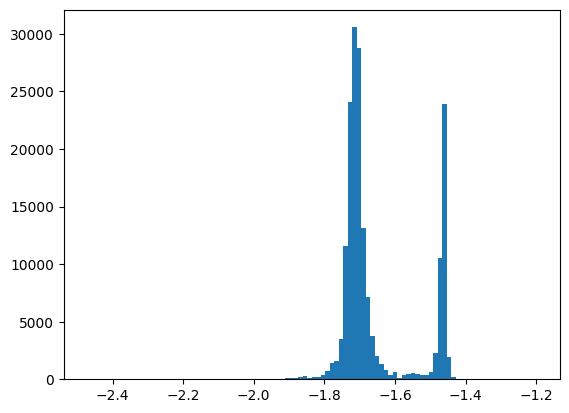

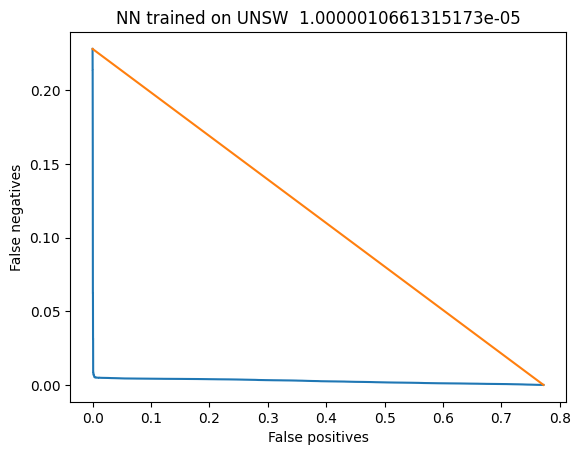

FPFNComplex(cutoff=Array([-3.5126548, -3.433521 , -3.188727 , ..., -1.3906305, -1.377939 ,
       -1.3778647], dtype=float32), fp_rate=Array([7.7187306e-01, 7.7186739e-01, 7.7186167e-01, ..., 1.1406345e-05,
       5.7031725e-06, 0.0000000e+00], dtype=float32, weak_type=True), fn_rate=Array([0.        , 0.        , 0.        , ..., 0.22812119, 0.22812119,
       0.2281269 ], dtype=float32, weak_type=True))
[-3.5126548 -3.433521  -3.188727  ... -1.3906305 -1.377939  -1.3778647]


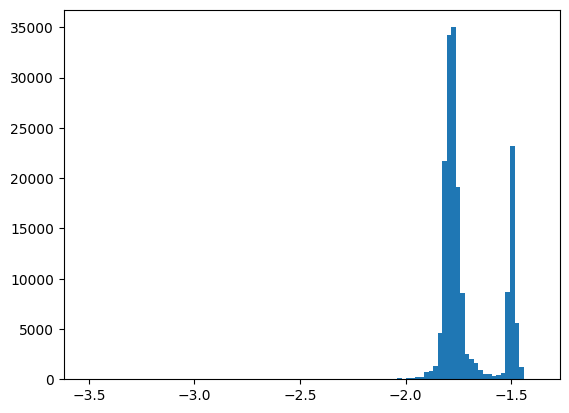

In [38]:
nn_g=NNPL(loss=mk_fp_relaxed_bce)

for beta in geomspace(beta_large,beta_small,10):
  nn_g.fit(loss_param=float(beta))
  nn_g.report(loss_param=float(beta))
  nn_g.plot(loss_param=float(beta))

In [39]:
!ls cal

cal.py	      dl.py   kal.py  mt.py   pal_test.py  rs.py      ts.py
composite.py  jal.py  md.py   pal.py  __pycache__  rsynth.py


/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [40]:
print(y_train.shape)

(175341,)


In [41]:
print(y_train.dtype)

bool


In [42]:
y_train[:10]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: attack_cat, dtype: bool

In [43]:
def binarise(x,red=None):#not ery efficient ofh well
  b=array([[i for i in _x.tobytes()] for _x in x],dtype=bool)
  red=b.max(axis=0)!=b.min(axis=0) if red is None else red
  print(red)
  return {'x':b[:,red],'mask':red}



In [44]:

#binarise train and test data - possibly silly?
Y={'generic_train':generic_train,'generic_test':generic_test}
X_train={'orig':{'x':x_train_orig},'norm':{'x':x_train_norm}}
X_test={'orig':{'x':x_test_orig},'norm':{'x':x_test_norm}}
redundant_dims={}
[(X_train.update({lab+'_bin':a}),redundant_dims.update({lab:b})) for lab,(a,b) in\
 [(lab,binarise(x['x'])) for (lab,x) in X_train.items()]]
                
[print(x['x'].shape) for k,x in X_train.items()]

NameError: name 'generic_train' is not defined

In [ ]:

[X_test.update({lab+'_bin':binarise(x['x'],red=redundant_dims[lab])}) for (lab,x) in X_test.items()]

In [ ]:
[print(k,v['x'].shape) for k,v in X_train.items()]

In [ ]:
def get_dat(x,y):
  r={}
  y=y.reshape(-1,1)

  r['fp']=(x&~y).mean(axis=0)
  r['fn']=((~x)&y).mean(axis=0)
  print(x.shape)
  r['dim_universe']=sum(x.max(axis=0)!=x.min(axis=0))
  r['avg']=x.mean(axis=0)

  return r
  
def plot_dat(d,l):
  subplots()
  print(l,':')
  if l=='fpfn':
    scatter(d['fp'],d['fn'])
  else:
    hist(d[l])
  

In [ ]:

print(generic_train.shape)
print(generic_test.mean())


In [ ]:
dat_bin_orig=get_dat(X_train['orig_bin']['x'],generic_train)
dat_bin_normalised=get_dat(X_train['norm_bin']['x'],generic_train)


print('Ambient dimension of original:',dat_bin_orig['dim_universe'])

print('Ambient dimension after mu,sigma=0,1 rescaling:',dat_bin_normalised['dim_universe'])

In [ ]:
print('Original:')
plot_dat(dat_bin_orig,'fp')
plot_dat(dat_bin_orig,'fn')
plot_dat(dat_bin_orig,'fpfn')
print(dat_bin_normalised['fn'])
#xscale('log')
#yscale('log')

In [ ]:
res={}
for l,xd in X_train.items():
  x=xd['x']
  
  m=RandomForestRegressor(n_jobs=-1)
  m.fit(x,generic_train)
  
  res[l]=m





In [ ]:
print(list(res))

In [ ]:
def fp_fn(mod,x,y,thresh):
  yp=mod.predict(x)>thresh
  return {'fp':(yp&(~y)).mean(),'fn':((~yp)&y).mean()}

In [ ]:
[print(l,*fp_fn(res[l],v['x'],generic_train,.5).items()) for l,v in X_train.items()]

In [ ]:
[print(l,*fp_fn(res[l],v['x'],generic_test,.5).items()) for l,v in X_test.items()]

In [ ]:
print(*fp_fn(res['orig']['bin'],x_binary_orig,generic,.5).items())

In [ ]:
print(*fp_fn(res['normalised']['bin'],x_binary_normalised,generic,.5).items())